In [10]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

In [11]:
def clean_pmi_data(pmi_dict):
    """
    Clean the PMI data and remove non-Chinese characters and stop words
    """
    # Define Chinese stop characters
    stop_chars = {
        '的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '上', '也', '很', '到', '说', '要', '去', '你', '会',
        '着', '没有', '看', '好', '自己', '这', '那', '他', '她', '它', '我们', '你们', '他们', '啊', '呀', '呢', '吗', '吧', '哦',
        '唉', '嗯', '哈', '呵', '啦', '哇', '咦', '哟', '呗', '啰', '嘛', '呐', '哩', '咯', '啵', '喔', '噢', '咚', '嘘', '嘿',
        '嗨', '哼', '呸', '哎', '喂', '嘻', '哼', '嗯', '唔', '呃', '诶'
    }
    
    # Define non-Chinese character pattern
    non_chinese_pattern = re.compile(r'[^\u4e00-\u9fa5]')
    
    cleaned_pmi = {}
    
    for key, value in pmi_dict.items():
        # Parse tuple-formatted keys
        if key.startswith("('") and key.endswith("')"):
            inner_str = key[2:-2]  # Remove "('" and "')"
            parts = inner_str.split("', '")
            if len(parts) == 2:
                char1, char2 = parts[0], parts[1]
                
                # Check character validity
                char1_valid = (not non_chinese_pattern.match(char1) and char1 not in stop_chars)
                char2_valid = (not non_chinese_pattern.match(char2) and char2 not in stop_chars)
                
                if char1_valid and char2_valid:
                    # Create standardized pair key
                    standard_pair = f"{char1}→{char2}"
                    cleaned_pmi[standard_pair] = value
    
    print(f"Number of PMI data before cleaning: {len(pmi_dict)}")
    print(f"Number of PMI data after cleaning: {len(cleaned_pmi)}")
    
    return cleaned_pmi

def load_and_process_pmi_data(file1, file2):
    """
    Load and process two PMI analysis files and perform data cleaning
    """
    # Load data
    with open(file1, 'r', encoding='utf-8') as f:
        pmi_data1 = json.load(f)
    
    with open(file2, 'r', encoding='utf-8') as f:
        pmi_data2 = json.load(f)
    
    print(f"Original Xinlang News PMI data count: {len(pmi_data1)}")
    print(f"Original China News PMI data count: {len(pmi_data2)}")
    
    # Clean data
    pmi1_cleaned = clean_pmi_data(pmi_data1)
    pmi2_cleaned = clean_pmi_data(pmi_data2)
    
    # Display cleaning result statistics
    print(f"\nCleaned Xinlang News PMI count: {len(pmi1_cleaned)}")
    print(f"Cleaned China News PMI count: {len(pmi2_cleaned)}")
    
    if pmi1_cleaned:
        pmi1_values = list(pmi1_cleaned.values())
        print(f"Xinlang News PMI statistics - Min: {min(pmi1_values):.3f}, Max: {max(pmi1_values):.3f}, Mean: {np.mean(pmi1_values):.3f}")
    
    if pmi2_cleaned:
        pmi2_values = list(pmi2_cleaned.values())
        print(f"China News PMI statistics - Min: {min(pmi2_values):.3f}, Max: {max(pmi2_values):.3f}, Mean: {np.mean(pmi2_values):.3f}")
    
    return pmi1_cleaned, pmi2_cleaned

def create_comparison_analysis(pmi1, pmi2):
    """
    Create comparison analysis of cleaned PMI data
    """
    # 1. Create DataFrame for analysis
    all_pairs = set(pmi1.keys()) | set(pmi2.keys())
    
    comparison_data = []
    for pair in all_pairs:
        pmi1_val = pmi1.get(pair, None)
        pmi2_val = pmi2.get(pair, None)
        
        # Only process pairs present in both files
        if pmi1_val is not None and pmi2_val is not None:
            pmi_diff = pmi2_val - pmi1_val
            abs_diff = abs(pmi_diff)
            comparison_data.append({
                'pair': pair,
                'pmi1': pmi1_val,
                'pmi2': pmi2_val,
                'pmi_diff': pmi_diff,
                'abs_diff': abs_diff
            })
    
    df = pd.DataFrame(comparison_data)
    
    # 2. Statistical analysis
    print("\n=== Cleaned PMI Comparison Statistical Analysis ===")
    
    # Common pairs
    common_pairs = set(pmi1.keys()) & set(pmi2.keys())
    print(f"Number of common pairs: {len(common_pairs)}")
    
    # Unique pairs in each dataset
    unique_pmi1 = set(pmi1.keys()) - set(pmi2.keys())
    unique_pmi2 = set(pmi2.keys()) - set(pmi1.keys())
    print(f"Number of unique pairs in Xinlang News: {len(unique_pmi1)}")
    print(f"Number of unique pairs in China News: {len(unique_pmi2)}")
    
    # PMI statistics
    if common_pairs:
        common_pmi1 = [pmi1[pair] for pair in common_pairs]
        common_pmi2 = [pmi2[pair] for pair in common_pairs]
        
        print(f"\nPMI statistics for common pairs:")
        print(f"Xinlang News - Mean: {np.mean(common_pmi1):.3f}, Max: {np.max(common_pmi1):.3f}, Min: {np.min(common_pmi1):.3f}")
        print(f"China News - Mean: {np.mean(common_pmi2):.3f}, Max: {np.max(common_pmi2):.3f}, Min: {np.min(common_pmi2):.3f}")
        
        diffs = [pmi2[pair] - pmi1[pair] for pair in common_pairs]
        print(f"PMI difference - Mean: {np.mean(diffs):.3f}, Max: {np.max(diffs):.3f}, Min: {np.min(diffs):.3f}")
        
        # Statistics of positive and negative differences
        positive_diff = sum(1 for diff in diffs if diff > 0)
        negative_diff = sum(1 for diff in diffs if diff < 0)
        zero_diff = sum(1 for diff in diffs if diff == 0)
        print(f"Difference distribution - Positive: {positive_diff}, Negative: {negative_diff}, Zero: {zero_diff}")
    
    return df, common_pairs, unique_pmi1, unique_pmi2

def create_pmi_visualizations(df, pmi1, pmi2, common_pairs):
    """
    Create visualizations for cleaned PMI data
    """
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'WenQuanYi Zen Hei', 'SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Scatter plot of PMI values for common pairs
    if common_pairs:
        common_pmi1 = [pmi1[pair] for pair in common_pairs]
        common_pmi2 = [pmi2[pair] for pair in common_pairs]
        
        axes[0,0].scatter(common_pmi1, common_pmi2, alpha=0.6, color='#456990', s=30)
        axes[0,0].plot([min(common_pmi1), max(common_pmi1)], [min(common_pmi1), max(common_pmi1)], 
                      'r--', alpha=0.8, label='y=x')
        axes[0,0].set_xlabel('Xinlang News PMI values')
        axes[0,0].set_ylabel('China News PMI values')
        axes[0,0].set_title('Comparison of PMI values for common pairs after cleaning')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # 2. PMI difference histogram
    if len(df) > 0:
        diffs = df['pmi_diff']
        axes[0,1].hist(diffs, bins=30, alpha=0.7, color='#48C0AA', edgecolor='black')
        axes[0,1].axvline(0, color='red', linestyle='--', label='Zero difference line')
        axes[0,1].set_xlabel('PMI difference (China News - Xinlang News)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('PMI difference distribution after cleaning')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Top PMI values comparison (Top 15)
    top_pmi1 = sorted(pmi1.items(), key=lambda x: x[1], reverse=True)[:15]
    top_pmi2 = sorted(pmi2.items(), key=lambda x: x[1], reverse=True)[:15]
    
    if top_pmi1 and top_pmi2:
        pairs1, values1 = zip(*top_pmi1)
        pairs2, values2 = zip(*top_pmi2)
        
        x_pos = np.arange(len(pairs1))
        width = 0.35
        
        axes[0,2].bar(x_pos - width/2, values1, width, label='Xinlang News', alpha=0.7, color='#456990')
        axes[0,2].bar(x_pos + width/2, values2, width, label='China News', alpha=0.7, color='#EF767A')
        axes[0,2].set_xlabel('Character Pairs')
        axes[0,2].set_ylabel('PMI values')
        axes[0,2].set_title('Top PMI values comparison after cleaning (Top 15)')
        axes[0,2].set_xticks(x_pos)
        axes[0,2].set_xticklabels(pairs1, rotation=45, fontsize=8)
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    
    # 4. PMI value distribution histogram
    if pmi1:
        axes[1,0].hist(list(pmi1.values()), bins=30, alpha=0.7, label='Xinlang News', color='#456990', density=True)
    if pmi2:
        axes[1,0].hist(list(pmi2.values()), bins=30, alpha=0.7, label='China News', color='#EF767A', density=True)
    axes[1,0].set_xlabel('PMI values')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('PMI value distribution comparison after cleaning')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Top PMI differences (Top 10)
    if len(df) > 0:
        top_diff = df.nlargest(10, 'abs_diff')
        bars = axes[1,1].barh(range(len(top_diff)), top_diff['abs_diff'], color='#F7BF67', alpha=0.7)
        axes[1,1].set_yticks(range(len(top_diff)))
        axes[1,1].set_yticklabels(top_diff['pair'])
        axes[1,1].set_xlabel('PMI absolute difference')
        axes[1,1].set_title('Top PMI differences after cleaning (Top 10)')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            axes[1,1].text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                          f'{width:.2f}', ha='left', va='center', fontsize=8)
    
    # 6. Data Volume Comparison
    data_counts = [len(pmi1), len(pmi2), len(common_pairs), 
                  len(set(pmi1.keys()) - common_pairs), 
                  len(set(pmi2.keys()) - common_pairs)]
    labels = ['Xinlang Total', 'China Total', 'Common Pairs', 'Xinlang Unique', 'China Unique']
    colors = ['#7DAEF0', '#EA8379', '#299D8F', '#E9C46A', '#B395BD']
    
    bars = axes[1,2].bar(labels, data_counts, color=colors, alpha=0.7)
    axes[1,2].set_ylabel('Pair Counts')
    axes[1,2].set_title('Data Volume Comparison after Cleaning')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, data_counts)):
        axes[1,2].text(i, count + max(data_counts)*0.01, str(count), 
                      ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./picture/cleaned_pmi_comparison_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


# Main execution function
def main():
    print("Starting to load and clean PMI data...")
    
    # load and clean data
    pmi1, pmi2 = load_and_process_pmi_data('./data/xinlangnews_pmi_analysis.json', './data/chinanews_pmi_analysis.json')
    
    if len(pmi1) == 0 or len(pmi2) == 0:
        print("Warning: Cleaned data is empty, cannot perform comparison analysis")
        return
    
    # Comparison analysis
    df, common_pairs, unique_pmi1, unique_pmi2 = create_comparison_analysis(pmi1, pmi2)
    
    # Create visualizations
    create_pmi_visualizations(df, pmi1, pmi2, common_pairs)
    
    # Save processed data
    df.to_csv('./data/cleaned_pmi_comparison_results.csv', index=False, encoding='utf-8-sig')
    
    # Save cleaned PMI data
    with open('./data/cleaned_pmi1.json', 'w', encoding='utf-8') as f:
        json.dump(pmi1, f, ensure_ascii=False, indent=2)
    
    with open('./data/cleaned_pmi2.json', 'w', encoding='utf-8') as f:
        json.dump(pmi2, f, ensure_ascii=False, indent=2)
    
    print(f"\nAnalysis complete! Results have been saved as:")
    print("- cleaned_pmi_comparison_analysis.png (visualization chart)")
    print("- cleaned_pmi_comparison_results.csv (detailed data)")
    print("- cleaned_pmi1.json, cleaned_pmi2.json (cleaned PMI data)")


Starting to load and clean PMI data...
Original Xinlang News PMI data count: 181393
Original China News PMI data count: 165590
Number of PMI data before cleaning: 181393
Number of PMI data after cleaning: 139084
Number of PMI data before cleaning: 165590
Number of PMI data after cleaning: 121757

Cleaned Xinlang News PMI count: 139084
Cleaned China News PMI count: 121757
Xinlang News PMI statistics - Min: -5.814, Max: 20.624, Mean: 1.937
China News PMI statistics - Min: -8.066, Max: 21.180, Mean: 2.607

=== Cleaned PMI Comparison Statistical Analysis ===
Number of common pairs: 47189
Number of unique pairs in Xinlang News: 91895
Number of unique pairs in China News: 74568

PMI statistics for common pairs:
Xinlang News - Mean: 1.864, Max: 20.624, Min: -5.809
China News - Mean: 1.888, Max: 21.180, Min: -8.066
PMI difference - Mean: 0.023, Max: 11.059, Min: -12.856
Difference distribution - Positive: 24646, Negative: 22543, Zero: 0


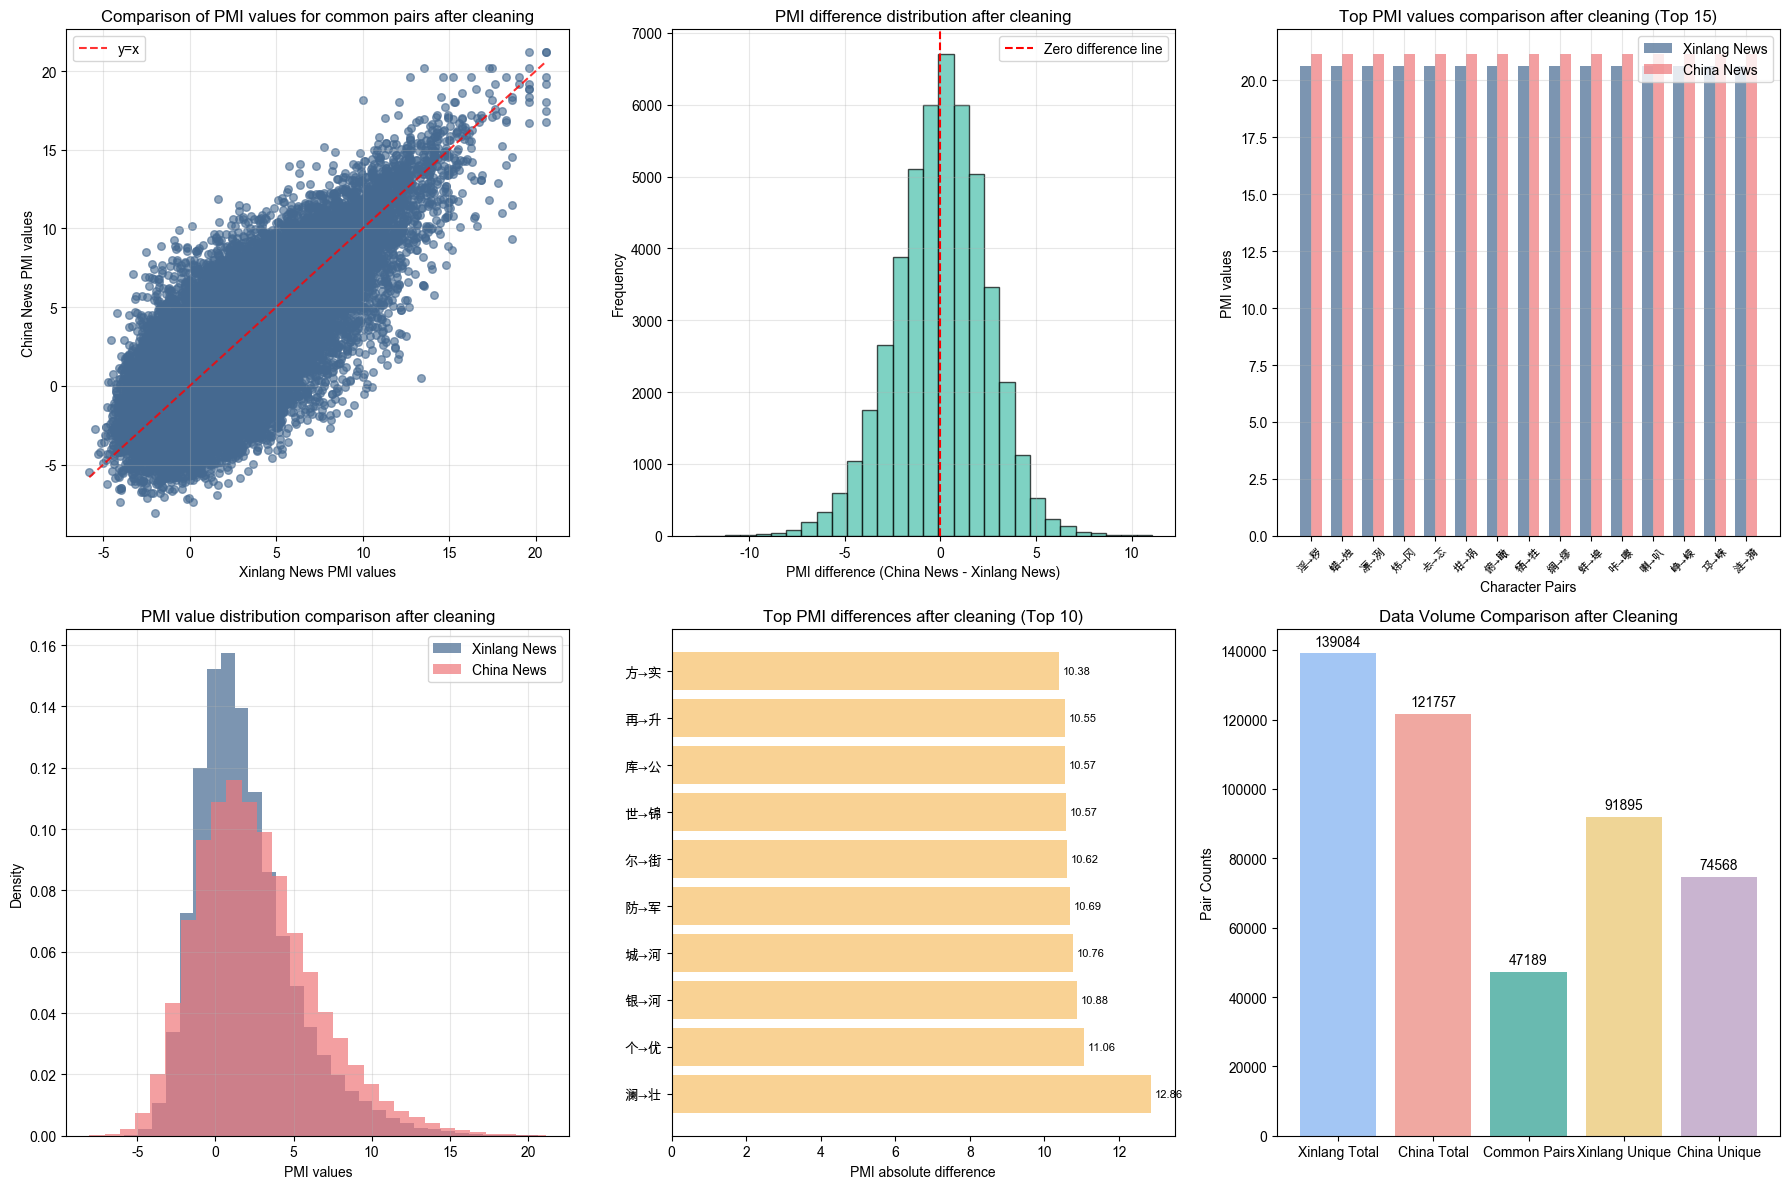


Analysis complete! Results have been saved as:
- cleaned_pmi_comparison_analysis.png (visualization chart)
- cleaned_pmi_comparison_results.csv (detailed data)
- cleaned_pmi1.json, cleaned_pmi2.json (cleaned PMI data)


In [12]:
if __name__ == "__main__":
    main()